## Download the necessary packages

In [ ]:
!pip install pyspark
!pip install nltk
import nltk
nltk.download('stopwords')
!pip install xgboost
!pip install lightgbm
!pip install synapse
!pip install synapseml
!pip install spark-nlp

!pip install nlpaug
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

## Create SparkContext and SparkSession and import data sets


In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, ArrayType, StringType, FloatType
from pyspark.sql.functions import udf, col, explode, count
from pyspark.ml import Pipeline, PipelineModel, Transformer, Estimator
from pyspark.ml.feature import VectorAssembler, Tokenizer, StopWordsRemover, CountVectorizer, IDF, Word2Vec
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC, OneVsRest
from synapse.ml.lightgbm import LightGBMClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params, TypeConverters
from xgboost.spark import SparkXGBClassifier
from sparknlp import DocumentAssembler
from sparknlp.base import EmbeddingsFinisher
from sparknlp.annotator import WordEmbeddingsModel, BertEmbeddings, Tokenizer, Normalizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display
from collections import defaultdict


## get file path
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
data_path = "/content/drive/MyDrive/Colab_Notebooks/"

ss = SparkSession.builder \
    .appName("group") \
    .config("spark.jars.packages",
           "com.microsoft.azure:synapseml_2.12:1.0.10,"
           "com.johnsnowlabs.nlp:spark-nlp_2.12:5.5.3")\
    .config("spark.jars.repositories",
           "https://mmlspark.azureedge.net/maven,"
           "https://repos.spark-packages.org")\
    .config("spark.sql.extensions", "io.fabric.analytics.spark.SynapseML") \
    .getOrCreate()

# 1. Loading data sets
df = ss.read.csv(data_path+"amazon_reviews.csv", header=True, escape='"', inferSchema=True)
print(f"df.count: {df.count()}, len(df.columns): {len(df.columns)}")
df.show(5)
df.printSchema()

Mounted at /content/drive/
df.count: 982, len(df.columns): 2
+--------------------+--------------+
|          reviewText|classification|
+--------------------+--------------+
|I bought this on ...|             1|
|I bought it for m...|             1|
|Received one - di...|             1|
|after doing some ...|             1|
|Just started unmo...|             1|
+--------------------+--------------+
only showing top 5 rows

root
 |-- reviewText: string (nullable = true)
 |-- classification: integer (nullable = true)



## Data Loading and Preprocessing

In [ ]:
# Define the model save path
MODEL_SAVE_PATH = data_path+"models"

def save_model(model, model_name):
    path = os.path.join(MODEL_SAVE_PATH, model_name)
    model.write().overwrite().save(path)

def load_model(model_name):
    path = os.path.join(MODEL_SAVE_PATH, model_name)
    return PipelineModel.load(path)

results = []

def evaluate_model(predictions, model_name):

   evaluator = MulticlassClassificationEvaluator(
        labelCol="classification",
        predictionCol="prediction",
        metricName="f1"
   )

   f1_score = evaluator.evaluate(predictions)
   return {"Model": model_name, "F1 Score": f1_score}

In [ ]:
# Define text cleaning functions
def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # separate word
    words = text.split()
    # stem extraction
    ps = PorterStemmer()
    words = [ps.stem(word) for word in words]
    return words

# Register the UDF, specifying the return type as a string
clean_text_udf = udf(clean_text, ArrayType(StringType()))
df_cleaned = df.withColumn("words", clean_text_udf(df['reviewText']))
df_xgb = df_cleaned.withColumn("classification", col("classification") - 1) # xgboost Requires labels 0 to n-1

# split data sets
train_df, test_df = df_cleaned.randomSplit([0.7, 0.3], seed=1)
train_xgb, test_xgb = df_xgb.randomSplit([0.7, 0.3], seed=1)
train_df.show(5)

+--------------------+--------------+--------------------+
|          reviewText|classification|               words|
+--------------------+--------------+--------------------+
|06.NOV.2012 - Bou...|             1|[nov, bought, the...|
|32 GB Micro SD ch...|             5|[gb, micro, sd, c...|
|32gb, this is jus...|             5|[gb, thi, is, jus...|
|4 stars for the e...|             4|[star, for, the, ...|
|64GB is pretty go...|             5|[gb, is, pretti, ...|
+--------------------+--------------+--------------------+
only showing top 5 rows



## Define generic feature engineering phases

In [ ]:
# Define feature engineering phases
stopword_remover = StopWordsRemover(
    inputCol="words",
    outputCol="filtered_words",
    stopWords=StopWordsRemover.loadDefaultStopWords("english")
)
count_vectorizer = CountVectorizer(
    inputCol="filtered_words",
    outputCol="tf",
    vocabSize=5000,
    minDF=2
)
idf = IDF(
    inputCol="tf",
    outputCol="tfidf",
    minDocFreq=2
)

# 1. Build Baseline Model

In [ ]:
# Define the logistic regression model
lr = LogisticRegression(
    featuresCol="tfidf",
    labelCol="classification",
    predictionCol="prediction",
    rawPredictionCol="lr_rawPred",
    probabilityCol="lr_prob",
    family="multinomial",
    maxIter=1000,
    regParam=0.01,
    elasticNetParam=0.2
)

model_name = "LogisticRegression"
model_path = os.path.join(MODEL_SAVE_PATH, model_name)

if os.path.exists(model_path):
    print(f"Loading existing {model_name} model...")
    model_lr = load_model(model_name)
else:
    print(f"Training new {model_name} model...")
    pipeline = Pipeline(stages=[
        stopword_remover,
        count_vectorizer,
        idf,
        lr
    ])
    model_lr = pipeline.fit(train_df)
    save_model(model_lr, model_name)

# Extract TF and IDF models for debugging
tf_model = model_lr.stages[1]  # CountVectorizerModel
idf_model = model_lr.stages[2] # IDFModel

# View glossary
print(f"\nTF Model Vocabulary (Top 20): {tf_model.vocabulary[:20]}")

# View IDF weights
idf_weights = idf_model.idf.toArray().tolist()
print(f"\nIDF Weights Sample: {idf_weights[:5]}")


# Model evaluation
predictions = model_lr.transform(test_df)
results.append(evaluate_model(predictions, "LogisticRegression"))

results_df = pd.DataFrame(results)
results_df

Loading existing LogisticRegression model...

TF Model Vocabulary (Top 20): ['card', 'thi', 'work', 'use', 'phone', 'wa', 'gb', 'memori', 'great', 'sandisk', 'sd', 'one', 'galaxi', 'price', 'speed', 'good', 'samsung', 'storag', 'veri', 'fast']

IDF Weights Sample: [0.6695185621665002, 0.5480792153070063, 0.7615374608867523, 1.0986122886681098, 1.3039822408983555]


,Model,F1 Score
0,LogisticRegression,0.702478


# 2. Building Different Data Analysis Models And Word Embedding Models



## 2.1 Data Analysis Models ( Decision Tree, Random Forest, XGBoost, LightGBM )

In [ ]:
svm = LinearSVC(
    featuresCol="tfidf",
    labelCol="classification",
    predictionCol="prediction",
    maxIter=1000,
    regParam=0.01
)
models = {
    "DecisionTree": DecisionTreeClassifier(
            featuresCol="tfidf",
            labelCol="classification",
            maxDepth=20,
            predictionCol="prediction",
            rawPredictionCol="dt_rawPred",
            probabilityCol="dt_prob",
            seed=1
        ),
    "RandomForest": RandomForestClassifier(
            featuresCol="tfidf",
            labelCol="classification",
            predictionCol="prediction",
            rawPredictionCol="rf_rawPred",
            maxDepth=10,
            seed=1,
            probabilityCol="rf_prob"
        ),
    "xgboost":    SparkXGBClassifier(
            features_col="tfidf",
            label_col="classification",
            seed=1,
            prediction_col="prediction"
        ),
    "lightgbm":    LightGBMClassifier(
           featuresCol="tfidf",
           labelCol="classification",
           objective="multiclass",
           boostingType="gbdt",
           seed=1
        ),
    "SVM_OneVsRest":    OneVsRest(
           classifier=svm,
           featuresCol="tfidf",
           labelCol="classification",
           predictionCol="prediction"
        )
    # Gradient boosted trees and SVM are not used (due to their requirement of labels from 0 to 1)

}

# Train and evaluate models
for model_name, classifier in models.items():

    model_path = os.path.join(MODEL_SAVE_PATH, model_name)

    if os.path.exists(model_path):
      print(f"Loading existing {model_name} model...")
      model = load_model(model_name)
    else:
      print(f"Training new {model_name} model...")
      pipeline = Pipeline(stages=[stopword_remover, count_vectorizer, idf, classifier])
      model = pipeline.fit(train_df if model_name not in ("xgboost", "SVM_OneVsRest") else train_xgb)
      save_model(model, model_name)

    predictions = model.transform(test_df if model_name not in ("xgboost", "SVM_OneVsRest") else test_xgb)
    results.append(evaluate_model(predictions, model_name))
results_df = pd.DataFrame(results)
print("\n===== Model Performance Comparison =====")
results_df

Loading existing DecisionTree model...
Loading existing RandomForest model...
Loading existing xgboost model...
Loading existing lightgbm model...
Training new SVM_OneVsRest model...

===== Model Performance Comparison =====


,Model,F1 Score
0,LogisticRegression,0.702478
1,DecisionTree,0.688231
2,RandomForest,0.707751
3,xgboost,0.714670
4,lightgbm,0.722369
5,SVM_OneVsRest,0.703775


## 2.2 Word Embedding Models

### 2.2.1 Word2Vec model

In [ ]:
# re-Define the logistic regression model for word embedding model

# Word2Vec model
word2vec = Word2Vec(
    vectorSize=100,
    minCount=2,
    inputCol="filtered_words",
    outputCol="features",
    seed=1
)

model_name = "Word2Vec"
model_path = os.path.join(MODEL_SAVE_PATH, model_name)

if os.path.exists(model_path):
    print(f"Loading existing {model_name} model...")
    model_w2v = load_model(model_name)
else:
    print(f"Training new {model_name} model...")
    pipeline_w2v = Pipeline(stages=[stopword_remover, word2vec, lr.setFeaturesCol("features")])
    model_w2v = pipeline_w2v.fit(train_df)
    save_model(model_w2v, model_name)

pred_w2v = model_w2v.transform(test_df)
results.append(evaluate_model(pred_w2v, "Word2Vec"))

results_df = pd.DataFrame(results)
print("\n===== Model Performance Comparison =====")
results_df

Loading existing Word2Vec model...

===== Model Performance Comparison =====


,Model,F1 Score
0,LogisticRegression,0.702478
1,DecisionTree,0.688231
2,RandomForest,0.707751
3,xgboost,0.714670
4,lightgbm,0.722369
5,SVM_OneVsRest,0.703775
6,Word2Vec,0.702989


### 2.2.2 GloVe model and Bert model

In [ ]:
class EmbeddingExtractor(Transformer, DefaultParamsReadable, DefaultParamsWritable):
    def __init__(self, inputCol="finished_embeddings", outputCol="features"):
        super().__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, dataset):
        # Define the UDF to extract the embedding of the first token and transform it into a DenseVector.
        extract_vector_udf = udf(lambda embeddings: Vectors.dense(embeddings[0]) if embeddings else Vectors.dense([]), VectorUDT())

        return dataset.withColumn(self.outputCol, extract_vector_udf(col(self.inputCol)))

# Define the set of embedded models
embedding_models = {
    "GloVe": {
        "model": WordEmbeddingsModel.pretrained("glove_100d"),
        "input_cols": ["document", "tokenized"]
    },
    "Bert": {
        "model": BertEmbeddings.pretrained("small_bert_L2_512", "en"),
        "input_cols": ["document", "tokenized"]
    }
}

# Public pre-processing phase
document_assembler = DocumentAssembler() \
    .setInputCol("reviewText") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("tokenized")

normalizer = Normalizer() \
    .setInputCols(["tokenized"]) \
    .setOutputCol("normalized") \
    .setLowercase(True)

embeddings_finisher = EmbeddingsFinisher() \
    .setInputCols(["embeddings"]) \
    .setOutputCols(["finished_embeddings"]) \
    .setOutputAsVector(False)

embedding_extractor = EmbeddingExtractor(inputCol="finished_embeddings", outputCol="features")

# Loop through each embedded model
for model_name, config in embedding_models.items():
    embedding_model = config["model"] \
        .setInputCols(config["input_cols"]) \
        .setOutputCol("embeddings")

    model_path = os.path.join(MODEL_SAVE_PATH, model_name)

    if os.path.exists(model_path):
      print(f"Loading existing {model_name} model...")
      model = load_model(model_name)
    else:
      print(f"Training new {model_name} model...")
      pipeline_embedding = Pipeline(stages=
                     [document_assembler,
                      tokenizer,
                      normalizer,
                      embedding_model,
                      embeddings_finisher,
                      embedding_extractor,
                      lr.setFeaturesCol("features")]
      )
      model = pipeline_embedding.fit(train_df)
      save_model(model, model_name)


    predictions = model.transform(test_df)
    results.append(evaluate_model(predictions, model_name))


results_df = pd.DataFrame(results)
print("\n===== Model Performance Comparison =====")
results_df

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
small_bert_L2_512 download started this may take some time.
Approximate size to download 81.5 MB
[OK!]
Loading existing GloVe model...
Loading existing Bert model...

===== Model Performance Comparison =====


,Model,F1 Score
0,LogisticRegression,0.702478
1,DecisionTree,0.688231
2,RandomForest,0.707751
3,xgboost,0.714670
4,lightgbm,0.722369
5,SVM_OneVsRest,0.703775
6,Word2Vec,0.702989
7,GloVe,0.706704
8,Bert,0.711236


# 3. Hyperparameter Tuning

## Define generic evaluators and cross-validator base configuration

In [ ]:
# Hyperparameter tuning module
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define generic evaluators
evaluator = MulticlassClassificationEvaluator(
    labelCol="classification",
    predictionCol="prediction",
    metricName="f1"
)

# Define the cross-validator base configuration
cv = CrossValidator(
    estimator=Pipeline(stages=[stopword_remover, count_vectorizer, idf, lr]),  # Placeholder, meaningless for now
    estimatorParamMaps=None,  # Follow-up settings
    evaluator=evaluator,
    numFolds=3,  # 3 fold cross validation
    seed=1,
    parallelism=2  # Parallelism
)

pipeline = Pipeline(stages=[stopword_remover, count_vectorizer, idf])
pipeline_middle = pipeline.fit(train_df)
train_middle = pipeline_middle.transform(train_df)
test_middle = pipeline_middle.transform(test_df)

pipeline_middle_xgb = pipeline.fit(train_xgb)
train_middle_xgb = pipeline_middle_xgb.transform(train_xgb)
test_middle_xgb = pipeline_middle_xgb.transform(test_xgb)

## 3.1 Logistic Regression Tuning

In [ ]:
# ======================
# 1. Logistic regression tuning
# ======================
lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.2, 0.5, 1.0]) \
    .build()

cv.setEstimator(Pipeline(stages=[lr])) \
  .setEstimatorParamMaps(lr_param_grid)

model_name = "Tuned_LogisticRegression"
model_path = os.path.join(MODEL_SAVE_PATH, model_name)

if os.path.exists(model_path):
    print(f"Loading existing {model_name} model...")
    best_model = load_model(model_name)
else:
    print(f"Training new {model_name} model...")
    lr_model = cv.fit(train_middle)
    best_model = lr_model.bestModel
    save_model(best_model, model_name)

best_lr = best_model.stages[0]
best_reg_param = best_lr._java_obj.getRegParam()
best_elastic_net_param = best_lr._java_obj.getElasticNetParam()
print("\n===== Best Tuned Parameters =====")
print(f"Best regParam: {best_reg_param}")
print(f"Best elasticNetParam: {best_elastic_net_param}")

lr_predictions = best_lr.transform(test_middle)
results.append(evaluate_model(lr_predictions, "Tuned_LogisticRegression"))

results_df = pd.DataFrame(results)
print("\n===== Model Performance Comparison =====")
results_df

Loading existing Tuned_LogisticRegression model...

===== Best Tuned Parameters =====
Best regParam: 0.01
Best elasticNetParam: 1.0

===== Model Performance Comparison =====


,Model,F1 Score
0,LogisticRegression,0.702478
1,DecisionTree,0.688231
2,RandomForest,0.707751
3,xgboost,0.714670
4,lightgbm,0.722369
5,SVM_OneVsRest,0.703775
6,Word2Vec,0.702989
7,GloVe,0.706704
8,Bert,0.711236
9,Tuned_LogisticRegression,0.709635


## 3.2 Decision Tree Tuning

In [ ]:
# ======================
# 2. Decision tree tuning
# ======================
dt = DecisionTreeClassifier(
    featuresCol="tfidf",
    labelCol="classification",
    seed=1
)

dt_param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 20]) \
    .addGrid(dt.minInstancesPerNode, [1, 5, 10]) \
    .build()

cv.setEstimator(Pipeline(stages=[dt])) \
  .setEstimatorParamMaps(dt_param_grid)

model_name = "Tuned_DecisionTree"
model_path = os.path.join(MODEL_SAVE_PATH, model_name)

if os.path.exists(model_path):
    print(f"Loading existing {model_name} model...")
    best_model = load_model(model_name)
else:
    print(f"Training new {model_name} model...")
    dt_model = cv.fit(train_middle)
    best_model = dt_model.bestModel
    save_model(best_model, model_name)

best_dt = best_model.stages[0]
best_maxDepth = best_dt._java_obj.getMaxDepth()
best_minInstancesPerNode = best_dt._java_obj.getMinInstancesPerNode()
print("\n===== Best Tuned Parameters =====")
print(f"Best maxDepth: {best_maxDepth}")
print(f"Best minInstancesPerNode: {best_minInstancesPerNode}")

dt_predictions = best_dt.transform(test_middle)
results.append(evaluate_model(dt_predictions, "Tuned_DecisionTree"))

results_df = pd.DataFrame(results)
print("\n===== Model Performance Comparison =====")
results_df

Loading existing Tuned_DecisionTree model...

===== Best Tuned Parameters =====
Best maxDepth: 10
Best minInstancesPerNode: 1

===== Model Performance Comparison =====


,Model,F1 Score
0,LogisticRegression,0.702478
1,DecisionTree,0.688231
2,RandomForest,0.707751
3,xgboost,0.714670
4,lightgbm,0.722369
5,SVM_OneVsRest,0.703775
6,Word2Vec,0.702989
7,GloVe,0.706704
8,Bert,0.711236
9,Tuned_LogisticRegression,0.709635


## 3.3 Random Forest Tuning

In [ ]:
# ======================
# 3. Random forest tuning
# ======================
rf = RandomForestClassifier(
    featuresCol="tfidf",
    labelCol="classification",
    seed=1,
)

rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .build()

cv.setEstimator(Pipeline(stages=[rf])) \
  .setEstimatorParamMaps(rf_param_grid)

model_name = "Tuned_RandomForest"
model_path = os.path.join(MODEL_SAVE_PATH, model_name)

if os.path.exists(model_path):
    print(f"Loading existing {model_name} model...")
    best_model = load_model(model_name)
else:
    print(f"Training new {model_name} model...")
    rf_model = cv.fit(train_middle)
    best_model = rf_model.bestModel
    save_model(best_model, model_name)

best_rf = best_model.stages[0]
best_maxDepth = best_rf._java_obj.getMaxDepth()
best_numTrees = best_rf._java_obj.getNumTrees()
print("\n===== Best Tuned Parameters =====")
print(f"Best maxDepth: {best_maxDepth}")
print(f"Best numTrees: {best_numTrees}")

rf_predictions = best_rf.transform(test_middle)
results.append(evaluate_model(rf_predictions, "Tuned_RandomForest"))

results_df = pd.DataFrame(results)
print("\n===== Model Performance Comparison =====")
results_df

Loading existing Tuned_RandomForest model...

===== Best Tuned Parameters =====
Best maxDepth: 20
Best numTrees: 30

===== Model Performance Comparison =====


,Model,F1 Score
0,LogisticRegression,0.702478
1,DecisionTree,0.688231
2,RandomForest,0.707751
3,xgboost,0.714670
4,lightgbm,0.722369
5,SVM_OneVsRest,0.703775
6,Word2Vec,0.702989
7,GloVe,0.706704
8,Bert,0.711236
9,Tuned_LogisticRegression,0.709635


## 3.4 XGBoost Tuning

In [ ]:
# ======================
# 4. XGBoost tuning
# ======================
xgb = SparkXGBClassifier(
    features_col="tfidf",
    label_col="classification",
    num_workers=1,
    seed=1
)

xgb_param_grid = ParamGridBuilder() \
    .addGrid(xgb.max_depth, [5, 10, 20]) \
    .addGrid(xgb.learning_rate, [0.1, 0.2, 0.3]) \
    .build()

cv.setEstimator(Pipeline(stages=[xgb])) \
  .setEstimatorParamMaps(xgb_param_grid)

model_name = "Tuned_XGBoost"
model_path = os.path.join(MODEL_SAVE_PATH, model_name)

if os.path.exists(model_path):
    print(f"Loading existing {model_name} model...")
    best_model = load_model(model_name)
else:
    print(f"Training new {model_name} model...")
    xgb_model = cv.fit(train_middle_xgb)
    best_model = xgb_model.bestModel
    save_model(best_model, model_name)

best_xgb = best_model.stages[0]
best_maxDepth = best_xgb.getOrDefault("max_depth")
best_learning_rate = best_xgb.getOrDefault("learning_rate")
print("\n===== Best Tuned Parameters =====")
print(f"Best maxDepth: {best_maxDepth}")
print(f"Best learning_rate: {best_learning_rate}")

xgb_predictions = best_xgb.transform(test_middle_xgb)
results.append(evaluate_model(xgb_predictions, "Tuned_XGBoost"))

results_df = pd.DataFrame(results)
print("\n===== Model Performance Comparison =====")
results_df

Loading existing Tuned_XGBoost model...

===== Best Tuned Parameters =====
Best maxDepth: 5
Best learning_rate: 0.2

===== Model Performance Comparison =====


,Model,F1 Score
0,LogisticRegression,0.702478
1,DecisionTree,0.688231
2,RandomForest,0.707751
3,xgboost,0.714670
4,lightgbm,0.722369
5,SVM_OneVsRest,0.703775
6,Word2Vec,0.702989
7,GloVe,0.706704
8,Bert,0.711236
9,Tuned_LogisticRegression,0.709635


## 3.5 LightGBM Tuning

In [ ]:
# ======================
# 5. LightGBM tuning
# ======================
lgb = LightGBMClassifier(
    featuresCol="tfidf",
    labelCol="classification",
    objective="multiclass",
    boostingType="gbdt",
    seed=1
)

lgb_param_grid = ParamGridBuilder() \
    .addGrid(lgb.numIterations, [150, 200, 250]) \
    .addGrid(lgb.maxDepth, [1, 5, 10]) \
    .build()

cv.setEstimator(Pipeline(stages=[lgb])) \
  .setEstimatorParamMaps(lgb_param_grid)

model_name = "Tuned_LightGBM"
model_path = os.path.join(MODEL_SAVE_PATH, model_name)

if os.path.exists(model_path):
    print(f"Loading existing {model_name} model...")
    best_model = load_model(model_name)
else:
    print(f"Training new {model_name} model...")
    lgb_model = cv.fit(train_middle)
    best_model = lgb_model.bestModel
    save_model(best_model, model_name)

best_lgb = best_model.stages[0]
best_numIterations = best_lgb.getOrDefault("numIterations") # Since the original function does not have a method for extracting the maxDepth parameter, maxDepth is not displayed.
print("\n===== Best Tuned Parameters =====")
print(f"Best numIterations: {best_numIterations}")

lgb_predictions = best_lgb.transform(test_middle)
results.append(evaluate_model(lgb_predictions, "Tuned_LightGBM"))

results_df = pd.DataFrame(results)
print("\n===== Model Performance Comparison =====")
results_df

Loading existing Tuned_LightGBM model...

===== Best Tuned Parameters =====
Best numIterations: 250

===== Model Performance Comparison =====


,Model,F1 Score
0,LogisticRegression,0.702478
1,DecisionTree,0.688231
2,RandomForest,0.707751
3,xgboost,0.714670
4,lightgbm,0.722369
5,SVM_OneVsRest,0.703775
6,Word2Vec,0.702989
7,GloVe,0.706704
8,Bert,0.711236
9,Tuned_LogisticRegression,0.709635


## 3.6 Word2Vec Tuning

In [ ]:
# ======================
# 6. Word2Vec tuning
# ======================
w2v = Word2Vec(
    vectorSize=100,
    minCount=2,
    inputCol="filtered_words",
    outputCol="features",
    seed=1
)

w2v_param_grid = ParamGridBuilder() \
    .addGrid(w2v.vectorSize, [50, 100, 200]) \
    .addGrid(w2v.windowSize, [3, 5, 7]) \
    .addGrid(w2v.stepSize, [0.025, 0.1, 0.3])\
    .build()

cv.setEstimator(Pipeline(stages=[stopword_remover, w2v, lr.setFeaturesCol("features")])) \
  .setEstimatorParamMaps(w2v_param_grid)

model_name = "Tuned_Word2Vec"
model_path = os.path.join(MODEL_SAVE_PATH, model_name)

if os.path.exists(model_path):
    print(f"Loading existing {model_name} model...")
    best_model = load_model(model_name)
else:
    print(f"Training new {model_name} model...")
    w2v_model = cv.fit(train_df)
    best_model = w2v_model.bestModel
    save_model(best_model, model_name)

best_w2v = best_model.stages[-2]
best_vectorSize = best_w2v.getOrDefault("vectorSize")
best_windowSize = best_w2v.getOrDefault("windowSize")
best_stepSize = best_w2v.getOrDefault("stepSize")
print("\n===== Best Tuned Parameters =====")
print(f"Best vectorSize: {best_vectorSize}")
print(f"Best windowSize: {best_windowSize}")
print(f"Best stepSize: {best_stepSize}")

w2v_predictions = best_model.transform(test_df)
results.append(evaluate_model(w2v_predictions, "Tuned_Word2Vec"))

results_df = pd.DataFrame(results)
print("\n===== Model Performance Comparison =====")
results_df

Loading existing Tuned_Word2Vec model...

===== Best Tuned Parameters =====
Best vectorSize: 200
Best windowSize: 7
Best stepSize: 0.1

===== Model Performance Comparison =====


,Model,F1 Score
0,LogisticRegression,0.702478
1,DecisionTree,0.688231
2,RandomForest,0.707751
3,xgboost,0.714670
4,lightgbm,0.722369
5,SVM_OneVsRest,0.703775
6,Word2Vec,0.702989
7,GloVe,0.706704
8,Bert,0.711236
9,Tuned_LogisticRegression,0.709635


## Model Performance Comparison After Tuning

Best Model:  Tuned_XGBoost 
Best Model F1 Score:  0.7301786949340769



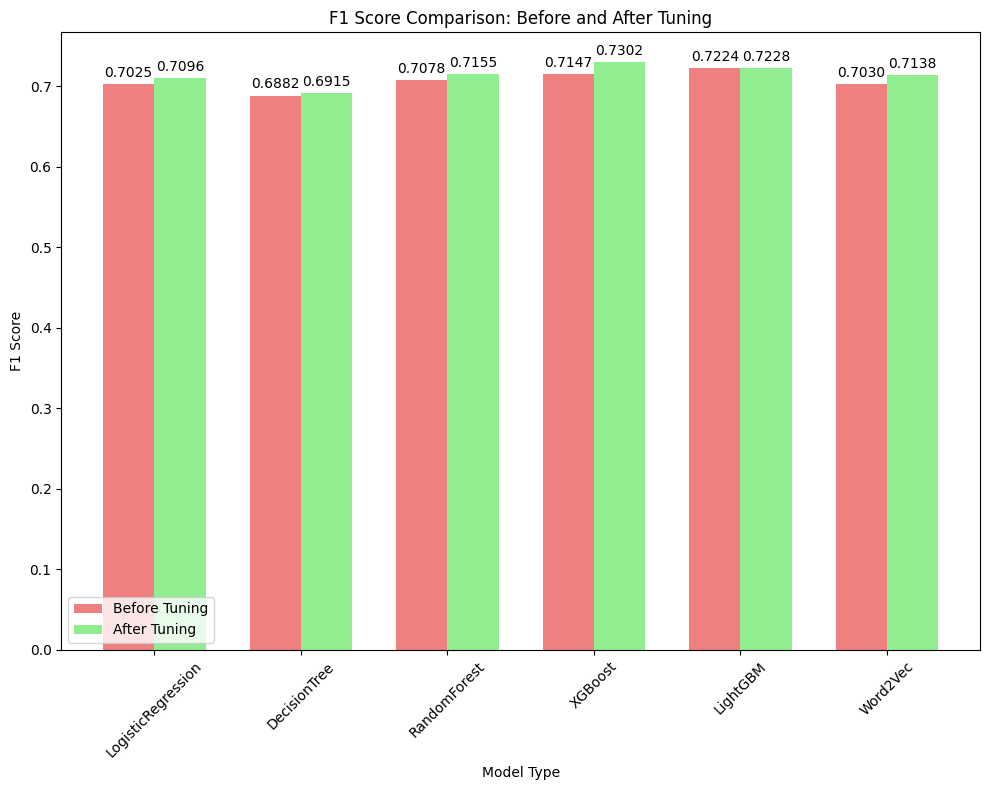

In [ ]:
# Getting the maximum F1 Score and its corresponding model
best_model_row = results_df.loc[results_df['F1 Score'].idxmax()]
print(f"Best Model:  {best_model_row['Model']} \nBest Model F1 Score:  {best_model_row['F1 Score']}\n")

# Create model comparison dictionary for tuning models vs original models
model_types = {
    "LogisticRegression": ["LogisticRegression", "Tuned_LogisticRegression"],
    "DecisionTree": ["DecisionTree", "Tuned_DecisionTree"],
    "RandomForest": ["RandomForest", "Tuned_RandomForest"],
    "XGBoost": ["xgboost", "Tuned_XGBoost"],
    "LightGBM": ["lightgbm", "Tuned_LightGBM"],
    "Word2Vec": ["Word2Vec", "Tuned_Word2Vec"]
}

# Prepare data for plotting
models = []
untuned_f1_scores = []
tuned_f1_scores = []

# Gather the F1 scores for untuned and tuned models
for model_type, models_to_compare in model_types.items():
    untuned_model = models_to_compare[0]
    tuned_model = models_to_compare[1]

    untuned_row = results_df[results_df['Model'] == untuned_model].iloc[0]
    tuned_row = results_df[results_df['Model'] == tuned_model].iloc[0]

    models.append(model_type)
    untuned_f1_scores.append(untuned_row['F1 Score'])
    tuned_f1_scores.append(tuned_row['F1 Score'])

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 8))

# Define bar width and positions for the bars
bar_width = 0.35
index = np.arange(len(models))

# Plot F1 Scores for untuned and tuned models
bars1 = ax.bar(index, untuned_f1_scores, bar_width, label='Before Tuning', color='lightcoral')
bars2 = ax.bar(index + bar_width, tuned_f1_scores, bar_width, label='After Tuning', color='lightgreen')

# Add text annotations (F1 Score values) on top of the bars
for i, bar in enumerate(bars1):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)

for i, bar in enumerate(bars2):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)

# Set axis labels and title
ax.set_xlabel('Model Type')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score Comparison: Before and After Tuning')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models, rotation=45)
ax.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# 4. Data Visualization Analysis

## 4.1 Distribution of Review Ratings (Bar and Pie Charts)

Num of Comment: 982


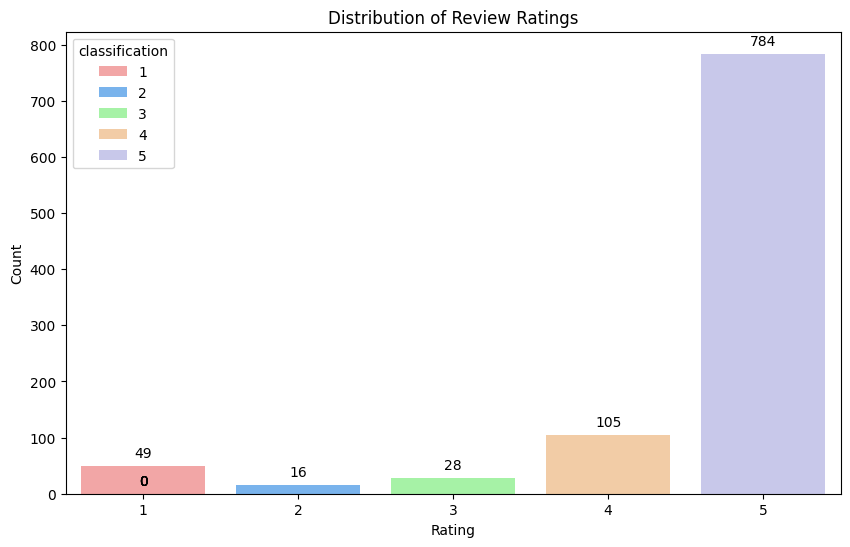

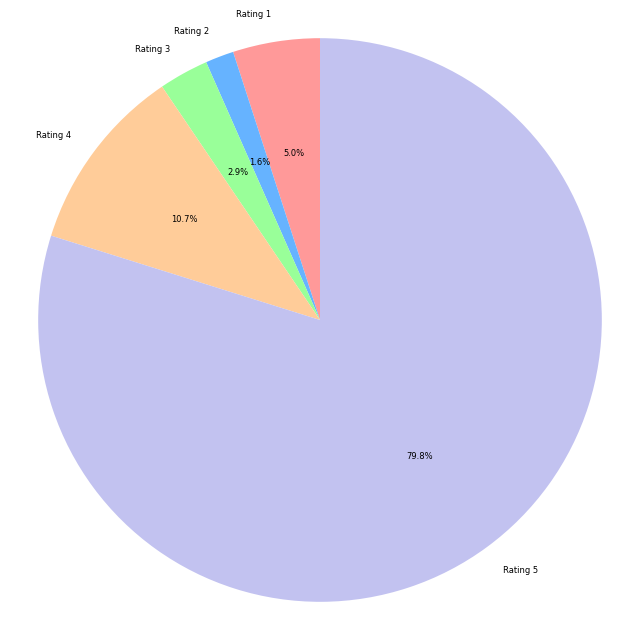

In [ ]:
 # Convert Spark DataFrame to Pandas DataFrame
df_pd = df.toPandas()
print(f"Num of Comment: {df.count()}")

classification_counts = df_pd['classification'].value_counts()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0']
sorted_classifications = sorted(classification_counts.index)
sorted_colors = [colors[i] for i in range(len(sorted_classifications))]

# Bar charts of the distribution of classifications
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='classification', data=df_pd, palette=sorted_colors, hue='classification')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 10, int(height),
            ha='center', va='bottom', fontsize=10)
plt.title('Distribution of Review Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Pie charts of the distribution of classifications
plt.figure(figsize=(8, 8))
labels = [f"Rating {x}" for x in sorted_classifications]
plt.pie(classification_counts[sorted_classifications], labels=labels, autopct='%1.1f%%', startangle=90, colors=sorted_colors, textprops={'fontsize': 6})
plt.axis('equal')
plt.show()

## 4.2 Comment Length Distribution by Rating (Boxplot)

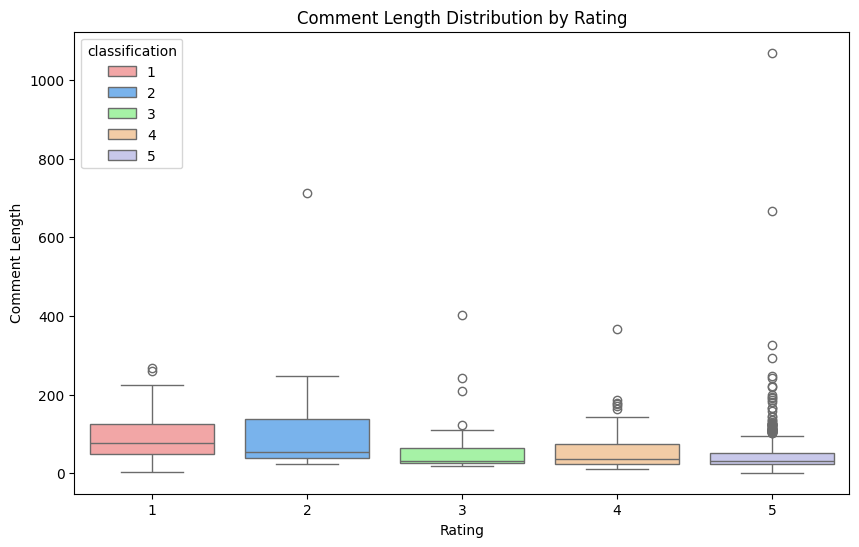

In [ ]:
# Define text cleaning functions
def clean(text):
    # Convert to lowercase
    text = text.lower()
    # separate word
    words = text.split()
    return words

# Register the UDF, specifying the return type as a string
clean_udf = udf(clean, ArrayType(StringType()))
df_clean = df.withColumn("words", clean_text_udf(df['reviewText']))

# words counted per comment (using cleaned split results)
df_pd['word_count'] = df_clean.select("words").toPandas()["words"].apply(lambda x: len(x))

# Box line plots by rating grouping
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='classification', y='word_count', data=df_pd, palette=sorted_colors, hue='classification')
plt.title('Comment Length Distribution by Rating')
plt.xlabel('Rating')
plt.ylabel('Comment Length')
plt.show()

## 4.3 Sentiment Score Distribution by Rating

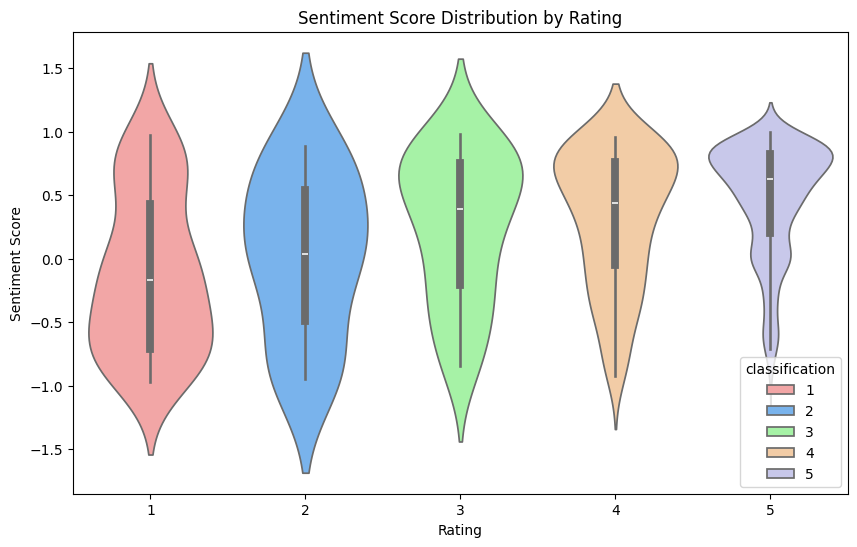

In [ ]:
# Calculate the sentiment score
sid = SentimentIntensityAnalyzer()
sentiment_udf = udf(lambda text: sid.polarity_scores(text)['compound'], FloatType())
df_sentiment = df.withColumn("sentiment_score", sentiment_udf(col("reviewText"))).toPandas()

# Mapping of distribution
plt.figure(figsize=(10, 6))
sns.violinplot(x="classification", y="sentiment_score", data=df_sentiment, palette=sorted_colors, hue='classification')
plt.title("Sentiment Score Distribution by Rating")
plt.xlabel("Rating")
plt.ylabel("Sentiment Score")
plt.show()

## 4.4 Statistical Indicators for Comment Length

In [ ]:
# Statistical indicators for calculating text length
stats = df_pd.groupby('classification')['word_count'].agg(
    mean='mean',
    mode=lambda x: x.mode()[0],
    median='median',
    variance='var',
    std='std',
    min='min',
    max='max',
    q25=lambda x: x.quantile(0.25),
    q50=lambda x: x.quantile(0.50),
    q75=lambda x: x.quantile(0.75)
)

# Output text length statistics by 'classification' grouping
print("Text Length Statistics by Rating:")
display(stats)

# Calculate global statistical indicators
global_stats = pd.DataFrame({
    'Mean': [df_pd['word_count'].mean()],
    'Mode': [df_pd['word_count'].mode()[0]],
    'Median': [df_pd['word_count'].median()],
    'Variance': [df_pd['word_count'].var()],
    'Std': [df_pd['word_count'].std()],
    'Min': [df_pd['word_count'].min()],
    'Max': [df_pd['word_count'].max()],
    'Range': [df_pd['word_count'].max() - df_pd['word_count'].min()],
    'Q25': [df_pd['word_count'].quantile(0.25)],
    'Q50': [df_pd['word_count'].quantile(0.50)],
    'Q75': [df_pd['word_count'].quantile(0.75)]
})

# Output global statistics
print("\n\nGlobal Text Length Statistics:")
display(global_stats)

Text Length Statistics by Rating:


,mean,mode,median,variance,std,min,max,q25,q50,q75
classification,,,,,,,,,,
1,96.795918,30,77.0,4370.874150,66.112587,4,268,48.0,77.0,124.00
2,128.125000,22,53.5,29643.050000,172.171571,22,713,39.0,53.5,138.25
3,69.500000,25,32.0,7392.259259,85.978249,19,403,25.0,32.0,64.00
4,57.866667,21,37.0,2620.308974,51.188954,11,367,24.0,37.0,75.00
5,45.399235,20,31.0,3025.374252,55.003402,1,1070,23.0,31.0,52.00




Global Text Length Statistics:


,Mean,Mode,Median,Variance,Std,Min,Max,Range,Q25,Q50,Q75
0,51.331976,21,33.0,3804.6644,61.681962,1,1070,1069,23.0,33.0,58.0


## 4.5 Correlation between Comment Length and Rating

In [ ]:
# Calculate the correlation coefficient between text length and rating
correlation = df_pd['word_count'].corr(df_pd['classification'])
print(f"Correlation between Comment Word Count and Rating: {correlation:.2f}")

Correlation between Comment Word Count and Rating: -0.24


## 4.6 TF-IDF Analysis and Word Clouds (Exclusion of co-occurring words)

High-frequency word analysis (TF-IDF):


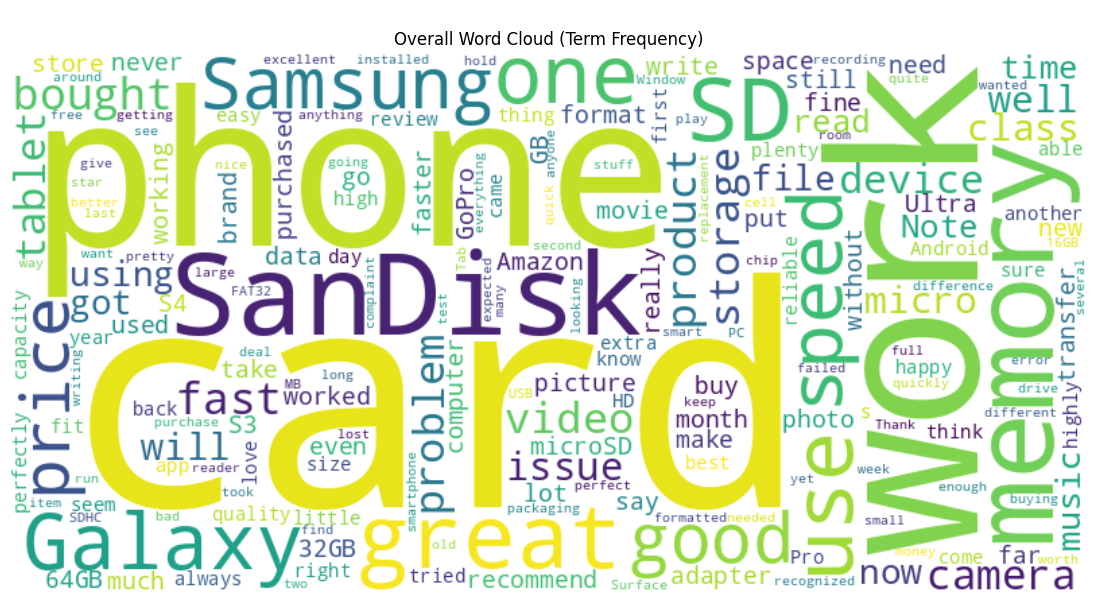


Top 10 Words Overall (Based on TF-IDF):
card: 775.64
phone: 557.30
wa: 538.40
gb: 536.43
use: 488.44
thi: 486.42
sandisk: 454.29
sd: 451.79
memori: 438.94
work: 430.74


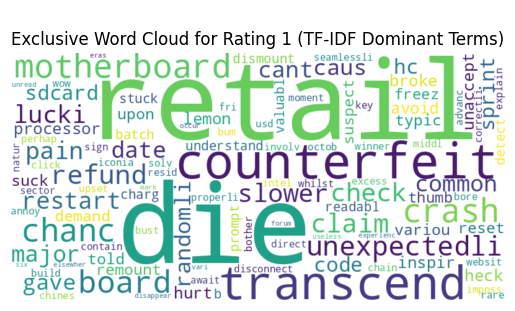


Unique Top 10 Keywords for Rating 1:
die: 26.96
retail: 26.96
counterfeit: 24.72
transcend: 23.17
motherboard: 23.17
crash: 22.02
chanc: 21.12
board: 20.40
unexpectedli: 20.40
refund: 19.78


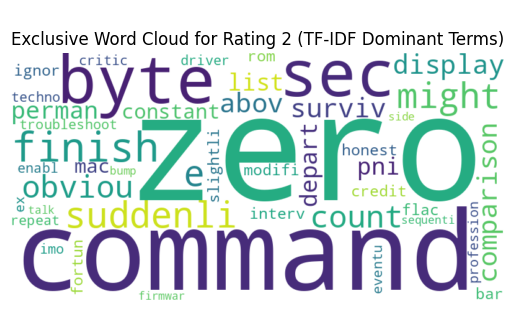


Unique Top 10 Keywords for Rating 2:
zero: 48.46
command: 23.17
byte: 22.02
sec: 21.12
finish: 17.38
suddenli: 15.30
e: 14.83
might: 14.43
obviou: 11.58
count: 11.58


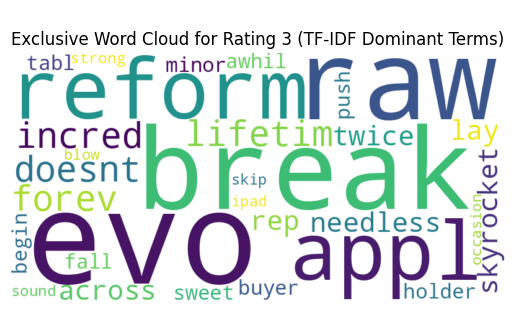


Unique Top 10 Keywords for Rating 3:
evo: 15.84
break: 11.58
raw: 11.58
reform: 11.58
appl: 11.01
lifetim: 10.56
doesnt: 10.56
incred: 10.56
forev: 10.56
rep: 5.79


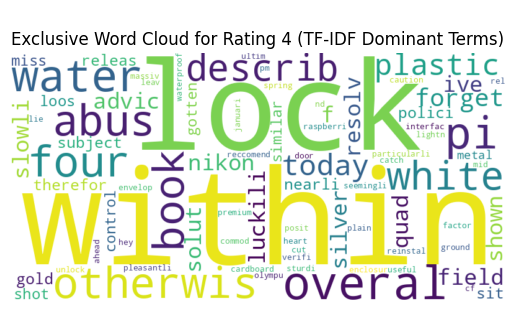


Unique Top 10 Keywords for Rating 4:
within: 24.72
lock: 21.12
overal: 18.77
water: 17.38
pi: 17.38
otherwis: 16.51
abus: 16.51
four: 16.51
book: 15.84
white: 15.84


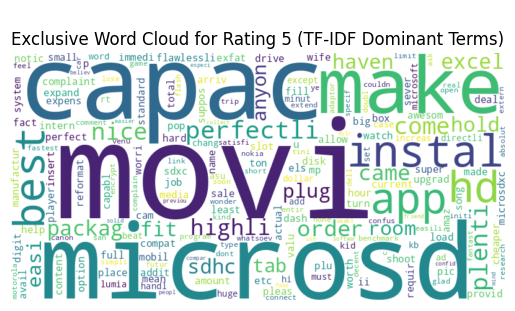


Unique Top 10 Keywords for Rating 5:
movi: 166.98
microsd: 154.20
capac: 149.94
make: 148.07
instal: 142.18
app: 132.42
hd: 131.66
best: 129.08
perfectli: 124.27
plenti: 120.36


In [ ]:
# =============== 1. Calculation of global and categorical TF-IDF statistics ===============

print("High-frequency word analysis (TF-IDF):")
word_category_scores = defaultdict(dict)

pipeline = Pipeline(stages=[stopword_remover, count_vectorizer, idf])
pipeline_model = pipeline.fit(df_clean)

# Get TF-IDF vectors for each classification
df_CleaningComplete = pipeline_model.transform(df_clean)
count_vectorizer_model = pipeline_model.stages[1]

# Get the vocabulary list and index mapping
vocab_list = count_vectorizer_model.vocabulary
index_to_word = {index: word for index, word in enumerate(vocab_list)}

# Convert to Pandas DataFrame
df_tfidf = df_CleaningComplete.select("classification", "tfidf").toPandas()

# Calculate the total TF-IDF score for each classification
for rating in sorted(df_tfidf['classification'].unique()):
    rating_df = df_tfidf[df_tfidf['classification'] == rating]
    tfidf_matrix = np.vstack(rating_df['tfidf'].apply(lambda x: x.toArray()))
    total_scores = tfidf_matrix.sum(axis=0)

    for idx, score in enumerate(total_scores):
        word = index_to_word.get(idx, f"Unknown_{idx}")
        word_category_scores[word][rating] = score

# Determine the dominant classification for each word
word_max_category = {}
for word, scores in word_category_scores.items():
    if scores:
        max_rating = max(scores, key=lambda k: scores[k])
        word_max_category[word] = max_rating

# =============== 2. Generate total word order and word clouds ===============

# Calculate global TF-IDF score
global_scores = defaultdict(float)
for word, category_scores in word_category_scores.items():
    global_scores[word] = sum(category_scores.values())

# Generate a global word cloud
text = ' '.join(df_pd['reviewText'])
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('\nOverall Word Cloud (Term Frequency)')
plt.show()

# Take the top 10 words with the highest scores
top_global_words = sorted(global_scores.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 Words Overall (Based on TF-IDF):")
for word, score in top_global_words:
    print(f"{word}: {score:.2f}")

# =============== 3. Public Word Recognition Module ===============

# Calculate the frequency of occurrence of words across classifications
word_cross_counts = defaultdict(int)
for word, scores in word_category_scores.items():
    # Count how many categories have significant existence (TF-IDF>0 is considered to exist)
    cross_categories = sum(1 for score in scores.values() if score > 0)
    word_cross_counts[word] = cross_categories

# Get the total number of classifications
total_ratings = len(df_tfidf['classification'].unique())

# Definition of a threshold of public words (words occurring in more than 60 per cent of classifications are considered public)
common_threshold = int(total_ratings * 0.6)
common_words = {
    word for word, count in word_cross_counts.items()
    if count > common_threshold
}


# =============== 4. Generation of exclusive word orders and word clouds for each category ===============

for rating in sorted(df_tfidf['classification'].unique()):
    # Filter out words exclusive to the category
    own_words = [word for word, max_r in word_max_category.items() if (max_r == rating) and (word not in common_words)]

    # Get the TF-IDF scores for these words under that classification
    scores = {word: word_category_scores[word].get(rating, 0) for word in own_words}

    # Generate categorised word clouds
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        collocations=False  # Disable phrase generation to avoid combinatorial interference
    ).generate_from_frequencies(scores)

    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'\nExclusive Word Cloud for Rating {rating} (TF-IDF Dominant Terms)')
    plt.show()

    # Take the top 10 words with the highest scores
    top_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]

    print(f"\nUnique Top 10 Keywords for Rating {rating}:")
    for word, score in top_words:
        print(f"{word}: {score:.2f}")

# 5. Baseline Model Improvement Methods
## We have tried the following methods to improve the initial baseline model
## (logistic regression):
1. Custom Feature Converter + Baseline Model
2. VADER sentiment compound features + Baseline Model
3. Self-Attention layer + Baseline Model
4. Baseline Model with category weights
5. PCA + Baseline Model
6. Ngram + Baseline Model

## Among these methods, **Custom Feature Converter + Baseline Model** has the best performance with F1 Score of **0.753035** (compared to the original F1 score: **0.702478**), which is designed by customising the feature layer based on the dataset format and feature analysis.

## 5.1 Custom Feature Converter + Baseline Model
## (Base on dataset format and features, customise the features layer)

In [ ]:
# ================== Custom Feature Converter ==================
class WordDistributionVectorizer(Estimator, HasInputCol, HasOutputCol,
                               DefaultParamsReadable, DefaultParamsWritable):

    def __init__(self, inputCol="words", outputCol="features"):
        super().__init__()
        self._set(inputCol=inputCol, outputCol=outputCol)

    def setInputCol(self, value):
        return self._set(inputCol=value)

    def setOutputCol(self, value):
        return self._set(outputCol=value)

    def _fit(self, dataset):
     input_col = self.getInputCol()
     output_col = self.getOutputCol()

     # Statistical word frequency distribution
     word_counts = (
        dataset.select(
            explode(col(input_col)).alias("word"),
            col("classification")
        )
        .groupBy("word", "classification")
        .agg(count("*").alias("count"))
        .persist()
     )

     # Collection of statistics
     word_class_counts = defaultdict(lambda: defaultdict(int))
     for row in word_counts.collect():
        word = row.word
        cls = row.classification
        cnt = row["count"]  # Use dictionary-style access to column values
        word_class_counts[word][cls] = cnt

     # Calculate distribution vectors
     word_distributions = {}
     for word, cls_counts in word_class_counts.items():
        total = sum(cls_counts.values())
        distribution = [
            cls_counts.get(rating, 0)/total if total > 0 else 0.0
            for rating in range(1, 6)
        ]
        word_distributions[word] = Vectors.dense(distribution)

     # Broadcast Dictionary
     sc = SparkContext.getOrCreate()
     broadcast_distributions = sc.broadcast(word_distributions)

     return WordDistributionModel(
        broadcast_distributions=broadcast_distributions,
        inputCol=input_col,
        outputCol=output_col
     )

class WordDistributionModel(Transformer, HasInputCol, HasOutputCol,
                           DefaultParamsReadable, DefaultParamsWritable):

    def __init__(self, broadcast_distributions, inputCol, outputCol):
        super().__init__()
        self.broadcast_distributions = broadcast_distributions
        self._set(inputCol=inputCol, outputCol=outputCol)

    def _transform(self, dataset):
        distributions = self.broadcast_distributions.value

        @udf(VectorUDT())
        def aggregate_vectors(words):
            vector_sum = [0.0] * 5
            valid_words = 0

            for word in words:
                vec = distributions.get(word, None)
                if vec:
                    valid_words += 1
                    for i in range(5):
                        vector_sum[i] += vec[i]

            return Vectors.dense(
                [v/valid_words if valid_words > 0 else 0.0 for v in vector_sum]
            )

        return dataset.withColumn(
            self.getOutputCol(),
            aggregate_vectors(col(self.getInputCol()))
        )


# ================== Building an Optimised Pipeline ==================
optimized_pipeline = Pipeline(stages=[
    stopword_remover,
    WordDistributionVectorizer(
        inputCol="filtered_words",
        outputCol="features"
    ),
    lr.setFeaturesCol("features")
])

# ================== model fit ==================

model_name = "CustomFeatures_with_LogisticRegression"
model_path = os.path.join(MODEL_SAVE_PATH, model_name)

print(f"Training {model_name} model...")
custom_model = optimized_pipeline.fit(train_df)

predictions = custom_model.transform(test_df)

results.append(evaluate_model(predictions, "Custom Features + LogisticRegression"))

results_df = pd.DataFrame(results)
print("\n===== Model Performance Comparison =====")
results_df

Training CustomFeatures_with_LogisticRegression model...

===== Model Performance Comparison =====


,Model,F1 Score
0,LogisticRegression,0.702478
1,DecisionTree,0.688231
2,RandomForest,0.707751
3,xgboost,0.714670
4,lightgbm,0.722369
5,SVM_OneVsRest,0.703775
6,Word2Vec,0.702989
7,GloVe,0.706704
8,Bert,0.711236
9,Tuned_LogisticRegression,0.709635


## 5.2 VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment compound features + Baseline Model

In [ ]:
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from nltk.sentiment.vader import SentimentIntensityAnalyzer

class SentimentScoreGenerator(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
    """
    Customised Transformer: dynamically generated sentiment score (VADER compound score)
    """
    def __init__(self, inputCol="reviewText", outputCol="sentiment_score"):
        super(SentimentScoreGenerator, self).__init__()
        self._set(inputCol=inputCol, outputCol=outputCol)
        self.sid = SentimentIntensityAnalyzer()

    def _transform(self, dataset):
        # Define UDF to calculate sentiment scores
        def get_sentiment(text):
            return float(self.sid.polarity_scores(text)['compound'])

        sentiment_udf = udf(get_sentiment, FloatType())

        return dataset.withColumn(
            self.getOutputCol(),
            sentiment_udf(col(self.getInputCol()))
        )

# Define feature engineering phases
sentiment_transformer = SentimentScoreGenerator(
    inputCol="reviewText",
    outputCol="sentiment_score"
)

assembler = VectorAssembler(
    inputCols=["sentiment_score"],
    outputCol="features"
)

pipeline = Pipeline(stages=[
    stopword_remover,
    sentiment_transformer,  # Dynamically generated sentiment scores
    assembler,
    lr.setFeaturesCol("features")
])


# Training model
model = pipeline.fit(train_df)

predictions = model.transform(test_df)

results.append(evaluate_model(predictions, "LR_with_SentimentScore"))

results_df = pd.DataFrame(results)
print("\n===== Model Performance Comparison =====")
results_df


===== Model Performance Comparison =====


,Model,F1 Score
0,LogisticRegression,0.702478
1,DecisionTree,0.688231
2,RandomForest,0.707751
3,xgboost,0.714670
4,lightgbm,0.722369
5,SVM_OneVsRest,0.703775
6,Word2Vec,0.702989
7,GloVe,0.706704
8,Bert,0.711236
9,Tuned_LogisticRegression,0.709635


## 5.3 Self-Attention layer + Baseline Model

In [ ]:
from pyspark.ml import Estimator, Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params, TypeConverters
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable

class KeywordExtractor(Estimator, HasInputCol, HasOutputCol):
    """
    Extract Top N keywords (based on TF-IDF scores) for each rating category (1-5 stars)
    """
    topN = Param(Params._dummy(), "topN", "Number of keywords per class", TypeConverters.toInt)

    def __init__(self, inputCol="classification", outputCol="keywords", topN=10):
        super().__init__()
        self._set(inputCol=inputCol, outputCol=outputCol)
        self._set(topN=topN)

    def _fit(self, dataset):
        # Top N keywords for each category extracted from TF-IDF statistic results
        word_scores = defaultdict(list)
        for word, scores in word_category_scores.items():
            for cls, score in scores.items():
                word_scores[cls].append((word, score))

        # TopN in order of ratings
        keywords_dict = {}
        for cls in range(1, 6):
            sorted_words = sorted(word_scores.get(cls, []), key=lambda x: x[1], reverse=True)
            keywords_dict[cls] = [w[0] for w in sorted_words[:self.getOrDefault("topN")]]

        return KeywordModel(keywords_dict=keywords_dict, outputCol=self.getOutputCol())

class KeywordModel(Transformer, HasOutputCol):
    def __init__(self, keywords_dict, outputCol):
        super().__init__()
        self.keywords_dict = keywords_dict
        self._set(outputCol=outputCol)  # Explicitly define the outputCol parameter

    def _transform(self, dataset):
        # Broadcast keyword dictionary to all nodes
        broadcast_keywords = SparkContext.getOrCreate().broadcast(self.keywords_dict)

        # Select keywords based on current rating category
        def get_keywords(cls):
            return broadcast_keywords.value.get(cls, [])

        keywords_udf = udf(get_keywords, ArrayType(StringType()))
        return dataset.withColumn(self.getOutputCol(), keywords_udf(col("classification")))


# Custom Attention Layer (requires inheritance from Transformer)
class AttentionWeighting(Transformer):
    def __init__(self, keywordsCol="keywords", wordsCol="filtered_words"):
        super().__init__()
        self.keywordsCol = keywordsCol
        self.wordsCol = wordsCol

    def _transform(self, dataset):
        # Calculate average attention weights (scalar)
        calculate_avg_attention = udf((lambda words, keywords: float(sum(0.7 if word in keywords else 0.3 for word in words) / len(words))), FloatType())
        return dataset.withColumn(
            "attention_weights",
            calculate_avg_attention(col(self.wordsCol), col(self.keywordsCol))
        )



# Add attention layer to Pipeline
pipeline = Pipeline(stages=[
    stopword_remover,
    count_vectorizer,
    idf,
    KeywordExtractor(inputCol="classification", topN=10),  # Extract Top 10 keywords for each category
    AttentionWeighting(keywordsCol="keywords", wordsCol="filtered_words"),
    VectorAssembler(inputCols=["tfidf", "attention_weights"], outputCol="features"),
    lr.setFeaturesCol("features")
])

# Training model
model = pipeline.fit(train_df)

predictions = model.transform(test_df)

results.append(evaluate_model(predictions, "LR_with_Attention"))

results_df = pd.DataFrame(results)
print("\n===== Model Performance Comparison =====")
results_df


===== Model Performance Comparison =====


,Model,F1 Score
0,LogisticRegression,0.702478
1,DecisionTree,0.688231
2,RandomForest,0.707751
3,xgboost,0.714670
4,lightgbm,0.722369
5,SVM_OneVsRest,0.703775
6,Word2Vec,0.702989
7,GloVe,0.706704
8,Bert,0.711236
9,Tuned_LogisticRegression,0.709635


## 5.4 Baseline Model with category weights

In [ ]:
# Add category weights to existing logistic regression parameters
lr_tuned = LogisticRegression(
    featuresCol="tfidf",
    labelCol="classification",
    weightCol="class_weight",  # New weight column
    maxIter=1000,
    regParam=0.01,
    elasticNetParam=0.05,
    family="multinomial"
)

# Calculate category weights (assigned by inverse category frequency)
from pyspark.sql import functions as F
class_counts = df.groupBy("classification").agg(F.count("*").alias("count")).collect()
total = df.count()
class_weights = {row["classification"]: total / (len(class_counts) * row["count"]) for row in class_counts}

# Add weight columns to training data
train_df = train_df.withColumn("class_weight", F.udf(lambda x: class_weights[x], FloatType())(F.col("classification")))
test_df = test_df.withColumn("class_weight", F.udf(lambda x: class_weights[x], FloatType())(F.col("classification")))

# Training model
pipeline = Pipeline(stages=[
    stopword_remover,
    count_vectorizer,
    idf,
    lr_tuned
])

model = pipeline.fit(train_df)

predictions = model.transform(test_df)

results.append(evaluate_model(predictions, "LR_with_class weighting"))

results_df = pd.DataFrame(results)
print("\n===== Model Performance Comparison =====")
results_df


===== Model Performance Comparison =====


,Model,F1 Score
0,LogisticRegression,0.702478
1,DecisionTree,0.688231
2,RandomForest,0.707751
3,xgboost,0.714670
4,lightgbm,0.722369
5,SVM_OneVsRest,0.703775
6,Word2Vec,0.702989
7,GloVe,0.706704
8,Bert,0.711236
9,Tuned_LogisticRegression,0.709635


## 5.5 PCA + Baseline Model

In [ ]:
from pyspark.ml.feature import PCA

# Local feature extraction using PCA
pca = PCA(k=100, inputCol="tfidf", outputCol="pca_features")

pipeline_cnn = Pipeline(stages=[
    stopword_remover,
    count_vectorizer,
    idf,
    pca,
    lr.setFeaturesCol("pca_features")
])

model_cnn = pipeline_cnn.fit(train_df)

predictions_cnn = model_cnn.transform(test_df)
results.append(evaluate_model(predictions_cnn, "LR_with_PCA"))

results_df = pd.DataFrame(results)
print("\n===== Model Performance Comparison =====")
results_df


===== Model Performance Comparison =====


,Model,F1 Score
0,LogisticRegression,0.702478
1,DecisionTree,0.688231
2,RandomForest,0.707751
3,xgboost,0.714670
4,lightgbm,0.722369
5,SVM_OneVsRest,0.703775
6,Word2Vec,0.702989
7,GloVe,0.706704
8,Bert,0.711236
9,Tuned_LogisticRegression,0.709635


## 5.6 Ngram + Baseline Model

In [ ]:
from pyspark.ml.feature import NGram

# Generate bigrams (binary phrases)
ngram = NGram(n=2, inputCol="filtered_words", outputCol="ngrams")

# Training model
pipeline = Pipeline(stages=[
    stopword_remover,
    ngram,
    count_vectorizer.setInputCol("ngrams"),
    idf,
    lr.setFeaturesCol("tfidf")
])

model = pipeline.fit(train_df)

predictions = model.transform(test_df)

results.append(evaluate_model(predictions, "LR_with_ngram"))

results_df = pd.DataFrame(results)
print("\n===== Model Performance Comparison =====")
results_df


===== Model Performance Comparison =====


,Model,F1 Score
0,LogisticRegression,0.702478
1,DecisionTree,0.688231
2,RandomForest,0.707751
3,xgboost,0.714670
4,lightgbm,0.722369
5,SVM_OneVsRest,0.703775
6,Word2Vec,0.702989
7,GloVe,0.706704
8,Bert,0.711236
9,Tuned_LogisticRegression,0.709635
